<a href="https://colab.research.google.com/github/rafisondi/ml-playground/blob/main/Baysian_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Baysian Tracking
Example from Lecture Slide 04 of Recursive Estimation by Rafael D'Andrea

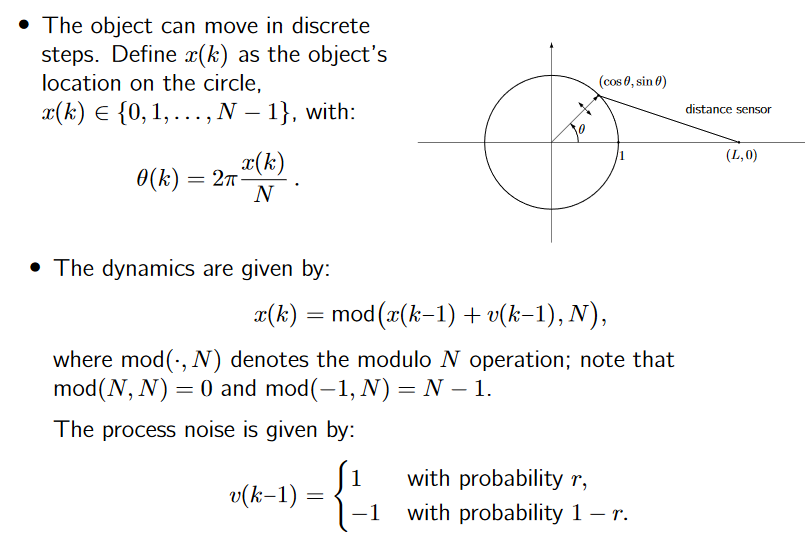

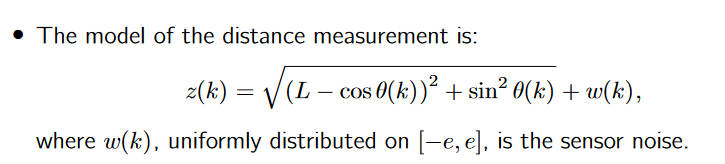

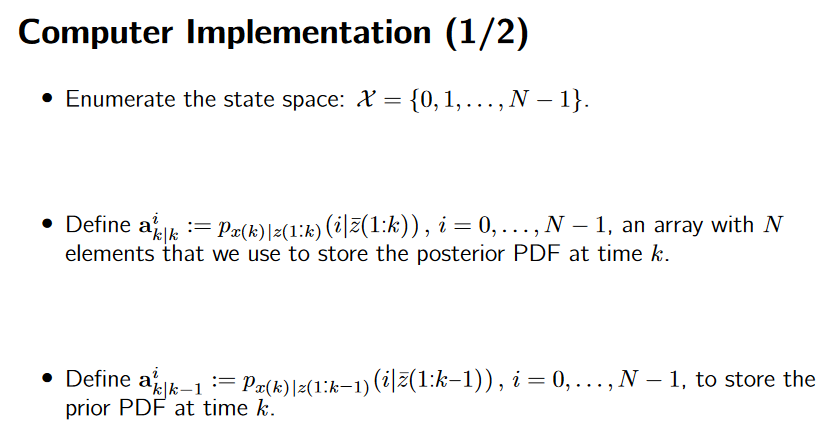


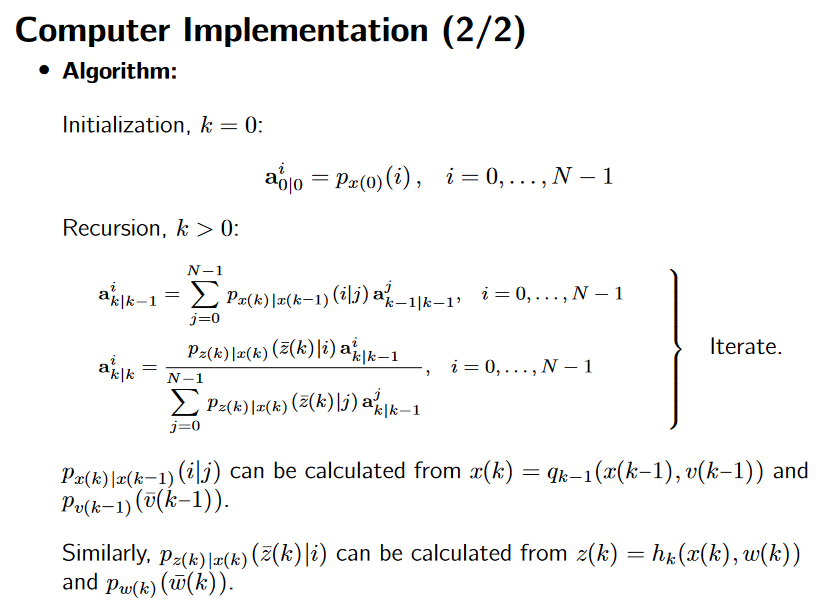

In [619]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [620]:
def disturbance(r):
    return 1 if np.random.uniform(0, 1) < r else -1

def next_state(x, v, N):
    return np.mod(x + v, N)

def update_prior(k):
    prior = np.zeros(N)
    for i in range(N):
        prior[i] = (1 - r_assumed) * post_grid[k - 1][(i + 1) % N] + r_assumed * post_grid[k - 1][(i - 1) % N]
    return prior

def update_posterior(k, p_prior):
    posterior = np.zeros(N)
    for i in range(N):
        distance = np.sqrt((L_assumed - np.cos(i * 2 * np.pi / N))**2 + np.sin(i * 2 * np.pi / N)**2)
        if abs(z_measured[k - 1] - distance) < e_assumed:
            posterior[i] = p_prior[i] / (2 * e_assumed)
    return posterior

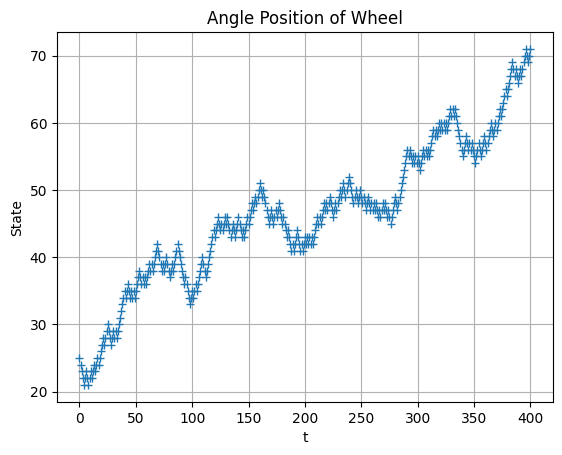

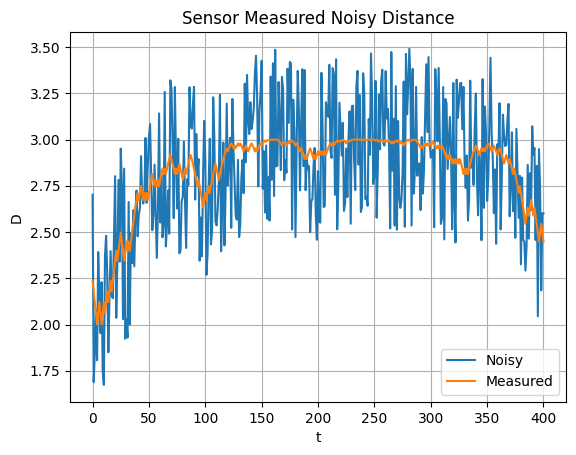

In [621]:
import numpy as np
import matplotlib.pyplot as plt

# Model parameters
N = 100
L = 2
r = 0.55  # Disturbance
e = 0.5  # Noise

# Assumed parameters ( we currently assume perfect knowlede of system params)
L_assumed = L
r_assumed = r
e_assumed = e

# Initialization for model
timesteps = 400
time = np.arange(0, timesteps + 1)
x_0 = 25
x = [x_0]

# Run Dynamics
for t in time[1:]:
    x.append(next_state(x[-1], disturbance(r), N))
x = np.array(x)

# Measure distance to point
z = np.sqrt((L - np.cos(x * 2 * np.pi / N))**2 + np.sin(x * 2 * np.pi / N)**2)
z_measured = z + e * (2 * np.random.rand(len(z)) - 1)

# Plotting
plt.figure()
plt.plot(time, x, '+')
plt.grid()
plt.xlabel('t')
plt.ylabel('State')
plt.title("Angle Position of Wheel")
plt.show()

plt.figure()
plt.plot(time, z_measured)
plt.plot(time, z)
plt.grid()
plt.xlabel('t')
plt.ylabel('D')
plt.legend(['Noisy', 'Measured'])
plt.title("Sensor Measured Noisy Distance")
plt.show()


In [622]:
# Initialize grid
post_grid = np.zeros((len(time), N))
post_grid[0, :] = np.full(N, 1 / N)

for k in range(1, len(time)):
    # Update Prior
    p_prior = update_prior(k)

    # Update Posterior (without normalization)
    post_grid[k, :] = update_posterior(k, p_prior)

    # Normalization (with check if zero)
    norm_const = np.sum(post_grid[k, :])
    if norm_const > 1e-6:
        post_grid[k, :] /= norm_const
    else:
        post_grid[k, :] = post_grid[0, :]  # Re-initialize to (original) uniform distribution
        print(f"\nRe-initializing estimator at time step {k}")

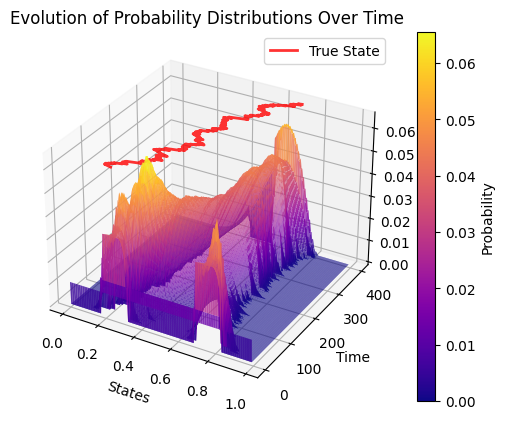

In [623]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

probabilities = post_grid  # Grid of probabilities
states = np.arange(0, N)  # State values
time = np.array(time)      # Time steps
x = np.array(x)            # True states over time

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
norm = plt.Normalize(np.min(probabilities), np.max(probabilities))
cmap = plt.get_cmap('plasma')

X, Y = np.meshgrid(states / N, time)
Z = probabilities
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.plasma, alpha=0.8)
scale = probabilities.max()
ax.plot3D(x / N, time, np.ones_like(time) * scale, 'r-', label='True State', linewidth=2, alpha=0.8)

# Set axis labels
ax.set_xlabel('States')
ax.set_ylabel('Time')
ax.set_zlabel('Probability')
plt.title('Evolution of Probability Distributions Over Time')

mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(probabilities)
fig.colorbar(mappable, ax=ax, label='Probability')
ax.legend()
plt.show()
